# Введение

Смените среду выполнения: "Среда выполнения"-> "Сменить среду выполнения" -> GPU

Ноутбук подготовлен для знакомства с [RuCLIP](https://github.com/ai-forever/ru-clip)

In [1]:
#@title Allowed Resources
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

# !nvidia-smi

CPU: 12
RAM GB: 15.9
PyTorch version: 2.0.1+cu117
CUDA version: 11.7
cuDNN version: 8500
device: cuda


## Restart colab session after installation
Reload the session if something doesn't work

In [4]:
!pip install --upgrade pip
!pip install Cython
!pip install youtokentome~=1.0.6
!pip cache purge
!pip install ruclip==0.0.2


  Using cached youtokentome-1.0.6.tar.gz (86 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "C:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
                 ^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\kuzga\AppData\Local\Temp\pip-build-env-1ov4ipxb\

Files removed: 20
     ---------------------------------------- 0.0/86.7 kB ? eta -:--:--
     -------------- ------------------------- 30.7/86.7 kB 1.3 MB/s eta 0:00:01
     -------------------------- ----------- 61.4/86.7 kB 812.7 kB/s eta 0:00:01
     -------------------------------------- 86.7/86.7 kB 980.8 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "C:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
                 ^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\kuzga\AppData\Local\Temp\pip-build-env-qq1h0tel\

In [3]:
!pip install -U huggingface_hub

   ---------------------------------------- 0.0/330.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/330.1 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/330.1 kB 495.5 kB/s eta 0:00:01
   ------------ ------------------------- 112.6/330.1 kB 939.4 kB/s eta 0:00:01
   --------------------- ------------------ 174.1/330.1 kB 1.2 MB/s eta 0:00:01
   ------------------------------------- -- 307.2/330.1 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 330.1/330.1 kB 1.7 MB/s eta 0:00:00


## RuCLIP
WARNING: specific RuCLIP like forward "model(text, image)" instead of classic(OpenAI CLIP) "model(image, text)"

In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
import ruclip

#you can change device to "cpu", if it doesn't start like that
model, processor = ruclip.load("ruclip-vit-base-patch32-384", device="cuda")

ModuleNotFoundError: No module named 'ruclip'

In [ ]:
import torch
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO
import pandas as pd
from google.colab import files

In [ ]:
# @title Define show_similarity function
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
def show_similarity(images, texts, similarity):
    input_resolution = 224
    preprocess = Compose([
        Resize(input_resolution, interpolation=Image.BICUBIC),
        CenterCrop(input_resolution),
        ToTensor()
    ])
    count = len(texts)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=similarity.min(), vmax=similarity.max())
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    print(len(images))
    for i, image in enumerate(images):
        if isinstance(image, str):
            image = Image.open(image)
        image = preprocess(image.convert('RGB'))
        plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

    for side in ['left', 'top', 'right', 'bottom']:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, len(images) - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title('Cosine similarity between text and image features', size=20)

In [ ]:
# define get_similarity function
# see documentation
def softmax(image_latents, text_latents):
  pass

In [ ]:
# define get_image function
def get_image(bs4):
  pass

8it [00:06,  1.17it/s]
8it [00:03,  2.14it/s]


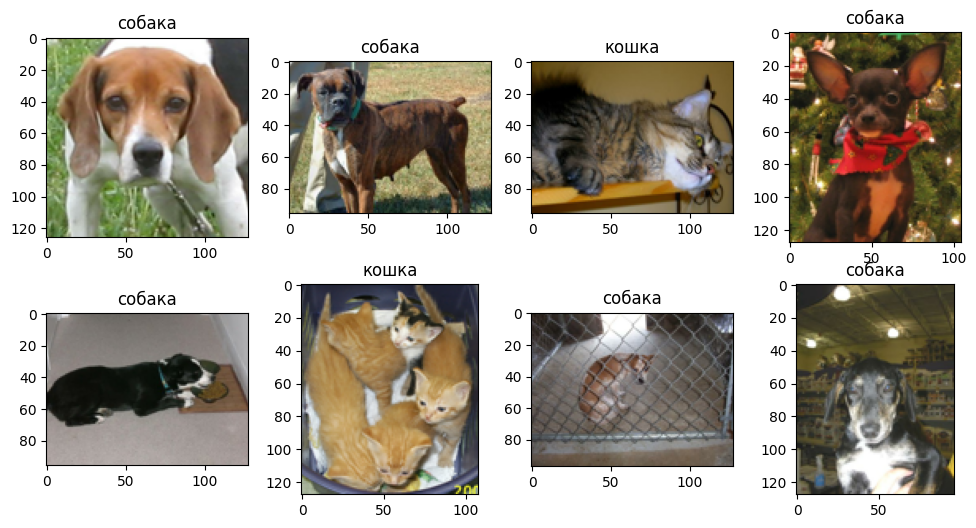

In [ ]:
# prepare images
bs4_urls = requests.get('https://raw.githubusercontent.com/ai-forever/ru-dolph/master/pics/pipelines/cats_vs_dogs_bs4.json').json()
images = [get_image(bs4_url) for bs4_url in bs4_urls]

# prepare classes
classes = ['кошка', 'собака']
templates = ['{}', 'это {}', 'на картинке {}', 'это {}, домашнее животное']

# predict
#you can change device to "cpu", if it doesn't start like that
predictor = ruclip.Predictor(model, processor, 'cuda', bs=8, templates=templates)
with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    pred_labels = predictor.run(images, text_latents)

    # image_latents = predictor.get_image_latents(images)
    # probs = softmax(image_latents, text_latents)

# show results
f, ax = plt.subplots(2,4, figsize=(12,6))
for i, (pil_img, pred_label) in enumerate(zip(images, pred_labels)):
    ax[i//4, i%4].imshow(pil_img)
    ax[i//4, i%4].set_title(classes[pred_label])

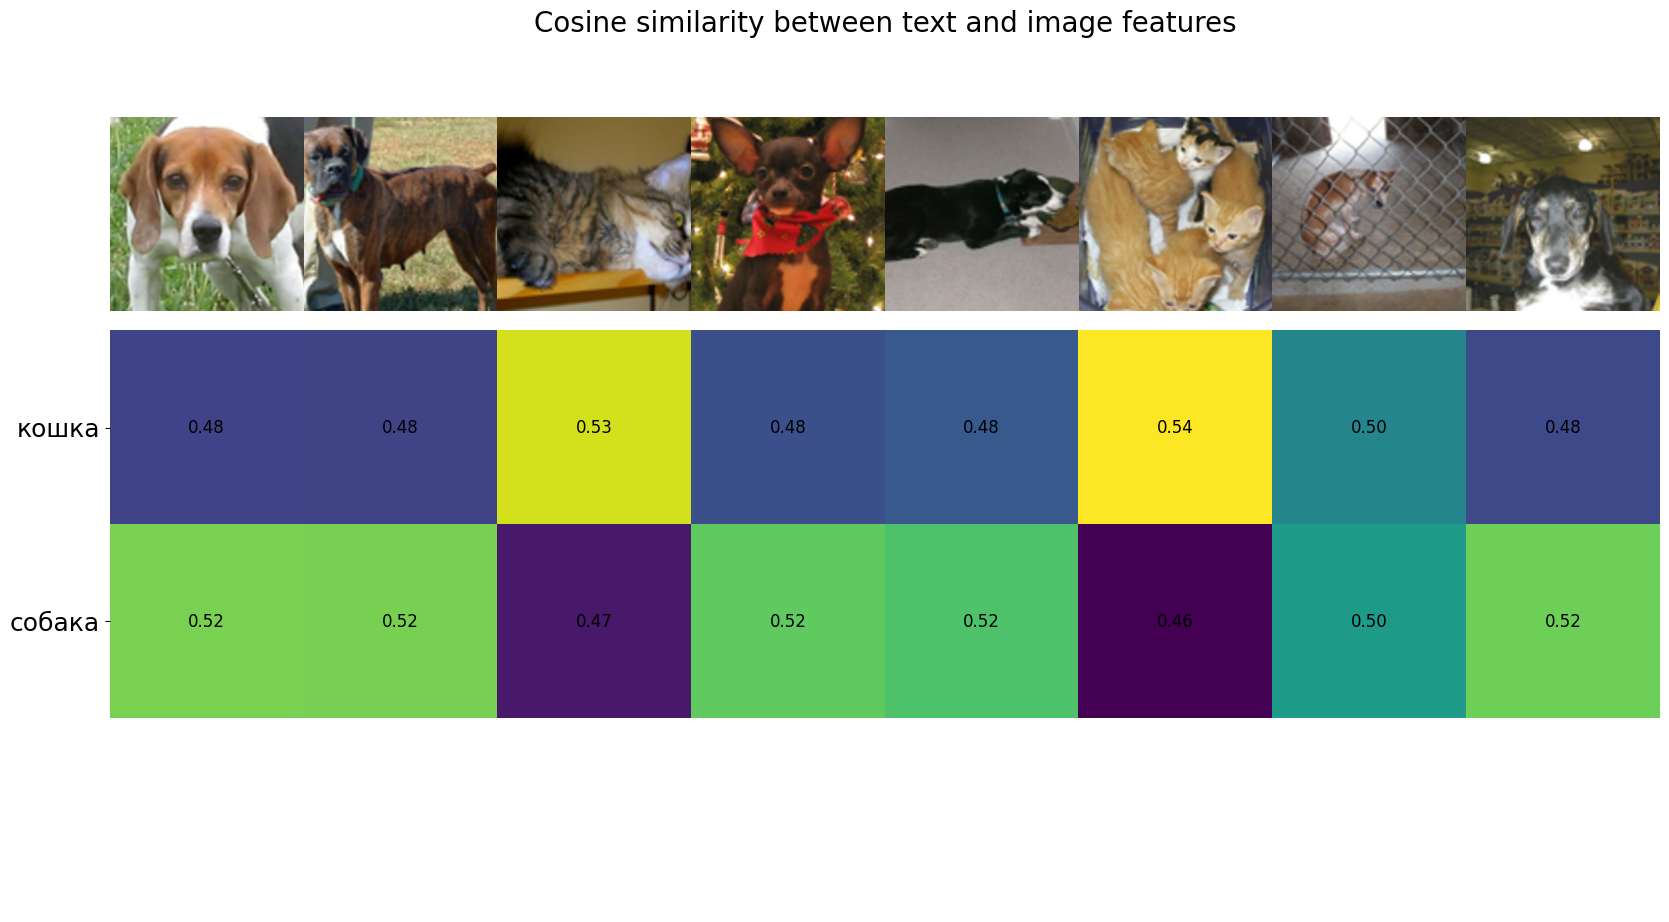

In [ ]:
show_similarity(images, classes, probs)